## 7.4 动量法

> **目标函数有关自变量的梯度代表了目标函数在自变量当前位置下降最快的方向**

### 7.4.1 梯度下降的问题

> 1. **考虑输入和输出都为二维向量$\boldsymbol{x}=[x1, x2]^\top$和目标函数为$f(\boldsymbol{x})=0.1x_1^2 + 2x_2^2$,此时$x_1$的系数从$1$变为$0.1$**

In [1]:
%matplotlib inline
import sys
sys.path.append("..") 
import d2lzh_pytorch.utils as d2l
import torch

epoch 20, x1 -0.943467, x2 -0.000073


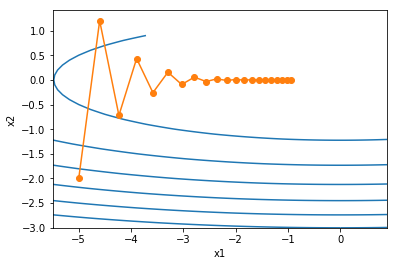

In [2]:
eta = 0.4

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

> 1. 如图,目标函数在竖直方向($x_2$方向)的斜率绝对值比在水平方向($x_1$方向)更大,所以给定学习率,那么迭代时使自变量在竖直方向比水平方向移动幅度更大
> 2. 需要一个较小的学习率从而避免自变量在竖直方向上越过目标函数最优解
> 3. 但这会造成自变量在水平方向上朝最优解移动变慢
> 4. 如果将学习率调过大,那么竖直方向会不断越过最优解并发散

epoch 20, x1 -0.387814, x2 -1673.365109


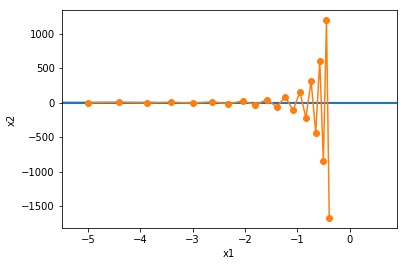

In [3]:
eta = 0.6
d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

### 7.4.2 动量法

> 1. **小批量梯度下降更为广义,设时间步$t$的小批量随机梯度为$\boldsymbol{g}_t$,自变量为$\boldsymbol{x}_t$,学习率为$\eta_t$**
> 2. **在时间步为0,创建速度变量$\boldsymbol{v}_0 = 0$,则在时间步$t>0$,迭代如下**
$$\boldsymbol{v}_t \leftarrow \gamma\boldsymbol{v}_{t-1} + \eta_t\boldsymbol{g}_t$$
$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{v}_t$$
**动量超参数满足$0 \leq \gamma < 1$,当$\gamma = 0$,动量法等价于小批量下降法**

epoch 20, x1 -0.062843, x2 0.001202


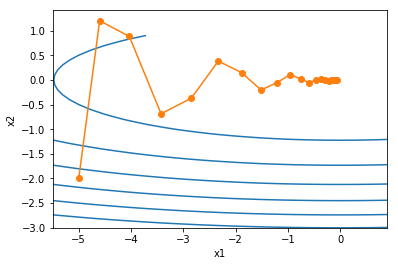

In [4]:
gamma, eta = 0.5, 0.4
def momentum_2d(x1, x2, v1, v2):
    v1 = gamma * v1 + eta * 0.2 * x1
    v2 = gamma * v2 + eta * 4 * x2
    return x1 - v1, x2 - v2, v1, v2

# 此时在竖直方向上更加平滑
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

epoch 20, x1 0.007188, x2 0.002553


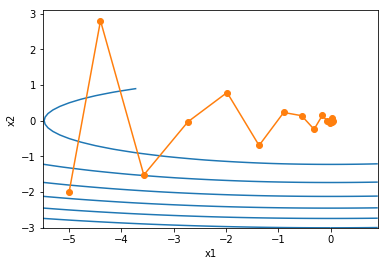

In [5]:
eta = 0.6
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

#### 7.4.2.1 指数加权移动平均

1. 给点超参数$0 \leq \gamma < 1$,当前时间步$t$的变量$y_t$是上一时间步变量$y_{t-1}$和当前时间步另一个变量$x_t$的线性组合
$$y_t = \gamma y_{t-1} + (1 - \gamma) x_{t}$$
2. 对$y_{t}进行展开$
$$\begin{aligned} y_t &= (1 - \gamma) x_{t} + \gamma y_{t-1} \\ &= (1 - \gamma) x_{t} + (1 - \gamma) \cdot \gamma x_{t-1} + \gamma^2 y_{t-2} \\ &= (1 - \gamma) x_{t}  + (1 - \gamma) \cdot \gamma x_{t-1} + (1 - \gamma)\cdot \gamma^2 x_{t-2} + \gamma^3 y_{t-3} \\ &\ldots \end{aligned} $$

3. 另$n=1 /(1-\gamma)$,那么$(1-1/n)^n=\gamma^{1/(1-\gamma)}$,又
$$\lim_{n \rightarrow \infty} (1 - \frac{1}{n})^n = \exp(-1) \approx 0.3679$$
所以当$\gamma \rightarrow 1$时,$\gamma^{1/(1-\gamma)}\approx \exp(-1)$,如果把$\exp(-1)$作为较小的值,那么可以忽略所有$\gamma^{1/(1-\gamma)}$和比其高阶的系数的项,如当$\gamma = 0.95$
$$y_t \approx 0.05 \sum_{i=0}^{19} 0.95^i x_{t-i}$$

4. 因此实际中可将$y_{t}$看做最近$1/(1-\gamma)$个$x_{t}$的加权平均值

#### 7.4.2.2 由指数加权移动平均理解动量法

1. 对动量法的速度变量做变形
$$\boldsymbol{v}_{t} \leftarrow \gamma\boldsymbol{v}_{t-1} + (1-\gamma)(\frac{\eta_{t}}{1-\gamma} \boldsymbol{g}_{t})$$

由指数加权移动平均的形式可得,指数变量$\boldsymbol{v}_{t}$实际对序列$\left\{ \eta_{t-i} \boldsymbol{g}_{t-i}/ (1-\gamma): i=0, \cdots , 1/(1-y) - 1 \right\}$做了指数加权移动平均

2. 动量法在每个时间步的自变量更新量近似于将最近$1/(1-\gamma)$个时间步的普通更新量（即学习率乘以梯度）做了指数加权移动平均后再除以$(1-\gamma)$

3. 在动量法中,自变量在各个方向上的移动幅度不仅取决当前梯度,还取决于过去的各个梯度在各个方向上是否一致

### 7.4.3 从零实现

In [9]:
features, labels = d2l.get_data_ch7()

def init_momentum_states():
    v_w = torch.zeros((features.shape[1], 1), dtype=torch.float32)
    v_b = torch.zeros(1, dtype=torch.float32)
    return (v_w, v_b)

def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        v.data = hyperparams['momentum'] * v.data + hyperparams['lr'] * p.grad.data
        p.data -= v.data

将动量超参数`momentum`设置为0.5,此时可看做为特殊的小批量梯度下降:其小批量随机梯度为最近2个时间步的2倍小批量梯度的加权和

loss: 0.242547, 0.067818 sec per epoch


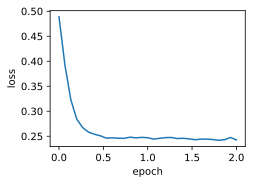

In [10]:
d2l.train_ch7(sgd_momentum, init_momentum_states(),
              {'lr': 0.02, 'momentum': 0.5}, features, labels)

将动量超参数momentum设置为0.9,此时可看做为特殊的小批量梯度下降:其小批量随机梯度为最近10个时间步的10倍小批量梯度的加权和

loss: 0.251204, 0.076764 sec per epoch


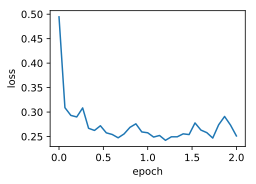

In [11]:
d2l.train_ch7(sgd_momentum, init_momentum_states(),
              {'lr': 0.02, 'momentum': 0.9}, features, labels)

可见目标函数值在后期迭代过程中的变化不够平滑。直觉上，10倍小批量梯度比2倍小批量梯度大了5倍，我们可以试着将学习率减小到原来的1/5

loss: 0.242986, 0.075798 sec per epoch


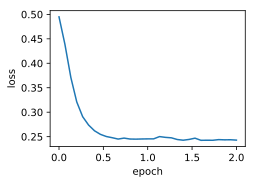

In [12]:
d2l.train_ch7(sgd_momentum, init_momentum_states(),
              {'lr': 0.004, 'momentum': 0.9}, features, labels)

### 7.4.4 简洁实现

loss: 0.246010, 0.061835 sec per epoch


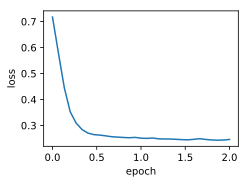

In [13]:
d2l.train_pytorch_ch7(torch.optim.SGD, {'lr': 0.004, 'momentum': 0.9},
                    features, labels)